In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import math as m
import random
import Bandit as bnd
import ContextBandit as cb
from multiprocess import Pool

In [24]:
def Par_KNN_UCB(bandit,X, theta, phi): ##X:context vector
    n = len(X)
    regrets = []
    n_arms = bandit.k #number of arms
    actions = []
    rewards = []
    assert(n >= n_arms)
    for a in range(n_arms): ##play each arm once regardless of context
        reward = bandit.pull(a, X[a])
        rewards.append(reward)
        actions.append(a)
        regrets.append(bandit.regret)
    for t in range(n_arms,n,1):
        if(t>1000):
            distances= cdist(X[:t], [X[t]], 'Euclidean')
            distances = [dist for sublist in distances for dist in sublist]
            index = np.zeros(n_arms) ## to store I_t,k
            pool = Pool(processes = n_arms)
            multiple_results = []
            for a in range(n_arms): ##evaluate k_a for all a
                multiple_results.append(pool.apply_async(park.par_k, (a, actions ,rewards,distances,theta,phi, )))
                index = [res.get() for res in multiple_results]
        else:
            distances= cdist(X[:t], [X[t]], 'Euclidean')
            distances = [dist for sublist in distances for dist in sublist]
            k_a = np.zeros(n_arms)
            index = np.zeros(n_arms) ## to store I_t,k
            for a in range(n_arms): ##evaluate k_a for all a
                U = np.zeros(t)
                for k in range(1,t+1, 1): ##calculate uncertainty on [t-1]
                    k_least = np.argpartition(distances, k-1)[:k] ## indices of k nearest neighbours
                    N = sum(np.array(actions)[k_least] == a) ##N_t,k
                    U[k-1] = m.sqrt(theta* m.log(t)/N) + phi(t) * distances[k_least[-1]] if (N!=0) else phi(t) * distances[k_least[-1]]
                k_a[a] = np.argmin(U) + 1
                k_least = np.argpartition(distances, int(k_a[a]-1))[:int(k_a[a])]
                N = sum(np.array(actions)[k_least] == a)
                S = sum(np.array(rewards)[k_least] * (np.array(actions)[k_least] == a))
                f_hat = S/N if (N!=0) else 0
                index[a] = f_hat + m.sqrt(theta* m.log(t)/N) + phi(t) * distances[k_least[-1]] if(N!=0) else f_hat + phi(t) * distances[k_least[-1]]  
        arm = np.argmax(index)
        reward = bandit.pull(arm, X[t])
        regrets.append(bandit.regret)
        actions.append(arm)
        rewards.append(reward)
    return actions, rewards, regrets

In [25]:
X = np.random.uniform(0,1, size = (300,4))
lambdas = [lambda x: np.prod([m.sin(xs * m.pi) for xs in x]),
           lambda x: np.prod([m.sin(xs * m.pi/2) for xs in x])]
bandit = cb.ContextBandit(lambdas)
actions,rewards,regrets4 = Par_KNN_UCB(bandit,X, 0.5, lambda a : 1)

In [28]:
regrets4

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.002362610250224285,
 0.03506499381289928,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.07580204691109771,
 0.07580204691109771,
 0.07580204691109771,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.26829016006402334,
 0.27962023742447745,
 0.27962023742447745,
 0.27962023742447745,
 0.27962023742447745,
 0.27962023742447745,
 0.3247201385473731,
 0.3247201385473731,
 0.3247201385473731,
 0.3247201385473731,
 0.3247201385473731,
 0.3247201385473731,
 0.3566210811516867,
 0.3566210811516867,
 0.3566210811516867,
 0.3566210811516867,
 0.5785747753109425,
 0.5785747753109425,
 0.5785747753109425,
 0.648590307989533,
 0.7283193

In [10]:
def KNN_UCB(bandit,X, theta, phi): ##X:context vector
    n = len(X)
    regrets = []
    n_arms = bandit.k #number of arms
    actions = []
    rewards = []
    assert(n >= n_arms)
    for a in range(n_arms): ##play each arm once regardless of context
        reward = bandit.pull(a, X[a])
        rewards.append(reward)
        actions.append(a)
        regrets.append(bandit.regret)
    for t in range(n_arms,n,1):
        distances= cdist(X[:t], [X[t]], 'Euclidean')
        distances = [dist for sublist in distances for dist in sublist]
        k_a = np.zeros(n_arms)
        index = np.zeros(n_arms) ## to store I_t,k
        for a in range(n_arms): ##evaluate k_a for all a
            U = np.zeros(t)
            for k in range(1,t+1, 1): ##calculate uncertainty on [t-1]
                k_least = np.argpartition(distances, k-1)[:k] ## indices of k nearest neighbours
                N = sum(np.array(actions)[k_least] == a) ##N_t,k
                U[k-1] = m.sqrt(theta* m.log(t)/N) + phi(t) * distances[k_least[-1]] if (N!=0) else phi(t) * distances[k_least[-1]]
            k_a[a] = np.argmin(U) + 1
            k_least = np.argpartition(distances, int(k_a[a]-1))[:int(k_a[a])]
            N = sum(np.array(actions)[k_least] == a)
            S = sum(np.array(rewards)[k_least] * (np.array(actions)[k_least] == a))
            f_hat = S/N if (N!=0) else 0
            index[a] = f_hat + m.sqrt(theta* m.log(t)/N) + phi(t) * distances[k_least[-1]] if(N!=0) else f_hat + phi(t) * distances[k_least[-1]]
        arm = np.argmax(index)
        reward = bandit.pull(arm, X[t])
        regrets.append(bandit.regret)
        actions.append(arm)
        rewards.append(reward)
    return actions, rewards, regrets

In [26]:
lambdas = [lambda x: np.prod([m.sin(xs * m.pi) for xs in x]),
           lambda x: np.prod([m.sin(xs * m.pi/2) for xs in x])]
bandit = cb.ContextBandit(lambdas)
actions,rewards,regrets5 = KNN_UCB(bandit,X, 0.5, lambda a : 1)

In [27]:
regrets5

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.002362610250224285,
 0.03506499381289928,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.058469038350556,
 0.07580204691109771,
 0.07580204691109771,
 0.07580204691109771,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.15249079715164704,
 0.26829016006402334,
 0.27962023742447745,
 0.27962023742447745,
 0.27962023742447745,
 0.27962023742447745,
 0.27962023742447745,
 0.3247201385473731,
 0.3247201385473731,
 0.3247201385473731,
 0.3247201385473731,
 0.3247201385473731,
 0.3247201385473731,
 0.3566210811516867,
 0.3566210811516867,
 0.3566210811516867,
 0.3566210811516867,
 0.5785747753109425,
 0.5785747753109425,
 0.5785747753109425,
 0.648590307989533,
 0.7283193

In [38]:
distances= cdist(X[:4], [X[4]], 'Euclidean')
distances

array([[0.63820873],
       [0.51534276],
       [0.64985191],
       [0.51366649]])

In [20]:
X = np.random.uniform(0,1, size = (1000,4))
lambdas = [lambda x: np.prod([m.sin(4*xs * m.pi) for xs in x]),
           lambda x: np.prod([m.cos(7*xs * m.pi) for xs in x])]
bandit = cb.ContextBandit(lambdas)
actions,rewards,regrets4, Us = u_KNN_UCB(bandit,X, 0.5, lambda a : 1)

In [32]:
 len(Us[1][-1][5:])

994

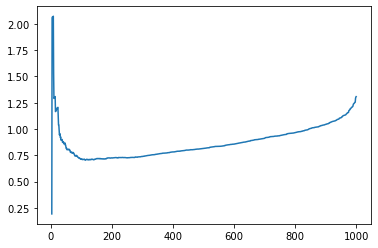

In [34]:
xs = np.linspace(4,999, 995)
plt.plot(xs, Us[1][-1][4:])

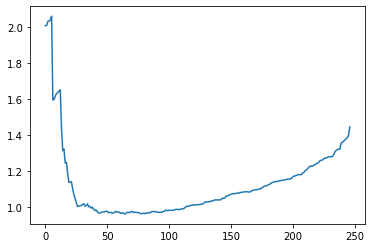

In [58]:
xs = range(len(Us[0][250][5:]))
plt.plot(xs, Us[0][250][5:])

In [65]:
lambdas = [lambda x: np.prod([m.sin(4*xs * m.pi) for xs in x]),
           lambda x: np.prod([m.cos(7*xs * m.pi) for xs in x])]
bandit = cb.ContextBandit(lambdas)
actions2,rewards2,regrets5, Us2 = u_KNN_UCB(bandit,X, 0.5, lambda a : 1)

In [175]:
def Uncertainty(k, actions, rewards, distances,theta,phi, a):
    t = len(actions)
    k_least = np.argpartition(distances, k - 1)[:k]
    N = sum(np.array(actions)[k_least] == a)
    U = m.sqrt(theta * m.log(t) / N) + phi(t) * distances[k_least[-1]] if (N != 0) else m.inf
    return U
    
def k_ternary_search(actions, rewards, distances, theta, phi, a):
    f = lambda k : Uncertainty(k, actions,rewards,distances,theta,phi, a)
    t = len(actions) - 1
    l = 1
    ls = [l]
    r = t
    rs = [r]
    while(True):
        c1 = l + m.floor((r - l)/ 3)
        c2 = l + 2 * m.floor((r-l)/3)
        if f(c1) > f(c2):
            l = c1
        elif f(c1)< f(c2):
            r = c2
        else:
            if c1 == c2:
                return c1
            else:
                l,r = c1,c2
        if abs(l-r) <= 1:
            break
    return m.floor((l+r)/2)
        


In [176]:
def u_KNN_UCB(bandit,X, theta, phi): ##X:context vector
    n = len(X)
    regrets = []
    n_arms = bandit.k #number of arms
    actions = []
    rewards = []
    assert(n >= n_arms)
    for a in range(n_arms): ##play each arm once regardless of context
        reward = bandit.pull(a, X[a])
        rewards.append(reward)
        actions.append(a)
        regrets.append(bandit.regret)
    for t in range(n_arms,n,1):
        distances= cdist(X[:t], [X[t]], 'Euclidean')
        distances = [dist for sublist in distances for dist in sublist]
        k_a = np.zeros(n_arms)
        index = np.zeros(n_arms) ## to store I_t,k
        for a in range(n_arms): ##evaluate k_a for all a
            k_a[a]= k_ternary_search(actions, rewards, distances, theta, phi, a)
            k_least = np.argpartition(distances, int(k_a[a]-1))[:int(k_a[a])]
            N = sum(np.array(actions)[k_least] == a)
            S = sum(np.array(rewards)[k_least] * (np.array(actions)[k_least] == a))
            f_hat = S/N if (N!=0) else 0
            index[a] = f_hat + m.sqrt(theta* m.log(t)/N) + phi(t) * distances[k_least[-1]] if(N!=0) else m.inf
        arm = np.argmax(index)
        reward = bandit.pull(arm, X[t])
        regrets.append(bandit.regret)
        actions.append(arm)
        rewards.append(reward)
    return actions, rewards, regrets

In [228]:
X = np.random.uniform(0,1, size = (20000,2))
lambdas = [lambda x: np.prod([m.sin(4*xs * m.pi) for xs in x]),
           lambda x: np.prod([m.cos(7*xs * m.pi) for xs in x])]
bandit = cb.ContextBandit(lambdas)
actions6,rewards6,regrets6= u_KNN_UCB(bandit,X, 1, lambda a : 15)

In [230]:
sum(np.subtract(regrets6[1:], regrets6[:-1]) == 0)

15633

In [231]:
%store regrets6

Stored 'regrets6' (list)


In [192]:
X = np.random.uniform(0,1, size = (1000,4))


In [219]:
lambdas = [lambda x: np.prod([m.sin(4*xs * m.pi) for xs in x]),
           lambda x: np.prod([m.cos(7*xs * m.pi) for xs in x])]
bandit = cb.ContextBandit(lambdas)
actions6,rewards6,regrets6= u_KNN_UCB(bandit,X, 1, lambda a : 24)

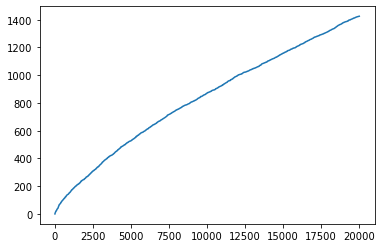

In [229]:
plt.plot(regrets6)